In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Si è ritenuto necessario aggiungere al dataset una colonna contenente i vari testi delle canzoni, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di aiuto per predire la popolarità di una canzone.
Abbiamo dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Di seguito è possibile trovare il codice (commentato) che implementa questa operazione. Si noti tuttavia che la sua esecuzione richede molto tempo (almeno un'ora), in quanto le richieste vanno spesso in timeout. Non è necessario eseguire le celle seguenti, in quanto i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [215]:
#%pip install lyricsgenius
#import lyricsgenius as lg

In [216]:
#import csv

#access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
#genius = lg.Genius(access_token)

#def get_lyrics(song_title, artist_name):
#    song = genius.search_song(song_title, artist_name)
#    return song.lyrics if song is not None else ""

#songs = pd.read_csv("songs.csv", sep=";")

#with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
#    writer = csv.writer(csv_file, delimiter="|")
#    writer.writerow(["title", "artist", "lyrics"])
#    for _, song in songs.iterrows():
#        is_ok = False
#        while not is_ok:
#           try:
#                lyrics = get_lyrics(song.title, song.artist)
#                is_ok = True
#                writer.writerow([song.title, song.artist, lyrics])
#            except Exception as e:
#                continue

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [235]:
songs_lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
songs_lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,88 ContributorsTranslationsEspañolPortuguêsKis...
1,Cupid - Twin Ver.,FIFTY FIFTY,1 ContributorTranslationsEnglishBahasa MelayuF...
2,BESO,ROSALÍA,29 ContributorsTranslationsPortuguêsEnglishDeu...
3,Boy's a liar Pt. 2,PinkPantheress,92 ContributorsTranslationsPortuguêsTürkçeDeut...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2 ContributorsNew Music Friday 12/02/22 Lyrics...
...,...,...,...
2380,Southbound,Beach Blvd,2 ContributorsMe & My Skate Lyrics[Skit]\nOh s...
2381,Dance with Somebody - Radio Version,Mando Diao,1 ContributorDance With Somebody - Radio Versi...
2382,Flow,Desire Machines,1 ContributorWhat Matters? Lyrics[Hook]\nLeave...
2383,Scared of the Dark,Everything Brighter,1 ContributorWay Home LyricsYa Ya Ya\n\nI hear...


Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [236]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 54 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
317,"Happy - From ""Despicable Me 2""",Pharrell Williams,
339,"Moves Like Jagger - Studio Recording From ""The...",Maroon 5,
446,CAN'T STOP THE FEELING! (from DreamWorks Anima...,Justin Timberlake,
684,Valerie (feat. Amy Winehouse) - Version Revisited,Mark Ronson,
686,Waka Waka (This Time for Africa) [The Official...,Shakira,
905,Free Fallin' - Live at the Nokia Theatre Los A...,John Mayer,
912,Intro,The xx,
947,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,Lana Del Rey,
1086,Jenny from the Block (feat. Jadakiss & Styles ...,Jennifer Lopez,


In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [237]:
songs_lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\nWe were good, we were gold\nKinda dream that can't be sold\nWe were right 'til we weren't\nBuilt a home and watched it burn\n\n[Pre-Chorus]\nMm, I didn't wanna leave you, I didn't wanna lie\nStarted to cry, but then remembered I\n\n[Chorus]\nI can buy myself flowers\nWrite my name in the sand\nTalk to myself for hours\nSay things you don't understand\nI can take myself dancing\nAnd I can hold my own hand\nYeah, I can love me better than you can\n\n[Post-Chorus]\nCan love me better, I can love me better, baby\nCan love me better, I can love me better, baby\n\n[Verse 2]\nPaint my nails cherry-red\nMatch the roses that you left\nNo remorse, no regret\nI forgive every word you said\nYou might also like[Pre-Chorus]\nOoh, I didn't wanna leave you, baby, I didn't wanna fight\nStarted to cry, but then rememb

Molti dei testi che hanno pochi "contributors" (meno di 20) sono sbagliati: la seguente funzione permette di rimuoverli, cioè di assegnare ad essi il valore stringa vuota (''). Inoltre, rimuove le parti di stringa che non corrispondono al reale testo della canzone dai testi validi. 

In [238]:
def clean_lyrics(text):
    if text != '':
        contributors, other = text.split("Contributor")
        text = other.split("Lyrics")[1].split("Embed")[0] if int(contributors) > 20 else ''
    return text

In [239]:
songs_lyrics["lyrics"] = songs_lyrics["lyrics"].map(clean_lyrics)

Il numero di canzoni che non possiedono testo è aumentato significativamente. Purtroppo questo problema è dovuto alle risposte fornite dall'API di Genius, quindi non è risolvibile a meno di non utilizzare un'altra API.

In [240]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 775 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
1,Cupid - Twin Ver.,FIFTY FIFTY,
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,
7,Calm Down (with Selena Gomez),Rema,
12,Die For You - Remix,The Weeknd,
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
29,Unholy (feat. Kim Petras),Sam Smith,
36,La Bachata,Manuel Turizo,
38,lovely (with Khalid),Billie Eilish,
46,Yandel 150,Yandel,
50,Double Fantasy (with Future),The Weeknd,


A questo punto il dataset è pronto per essere processato. Importiamo quindi le librerie necessarie per il NLP.

In [241]:
%pip install nltk
import nltk

%pip install langdetect
from langdetect import detect

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Per prima cosa, aggiungiamo al DataFrame una colonna contenente la lingua in cui è cantata la canzone, utilizzando la funzione **detect** del package **langdetect**.

In [242]:
def detect_language(text):
    return detect(text) if text != '' else None

In [250]:
songs_lyrics["language"] = songs_lyrics["lyrics"].apply(detect_language)
songs_lyrics

,title,artist,lyrics,language
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en
1,Cupid - Twin Ver.,FIFTY FIFTY,,None
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None
...,...,...,...,...
2380,Southbound,Beach Blvd,,None
2381,Dance with Somebody - Radio Version,Mando Diao,,None
2382,Flow,Desire Machines,,None
2383,Scared of the Dark,Everything Brighter,,None


Notare come le canzoni senza testo o il cui testo è stato precedentemente scartato a causa dei pochi "contributors" abbiano il valore None nella colonna **language**.

La distribuzione dei valori mostra inoltre come la stragrande maggioranza delle canzoni che possiedono un testo "valido" siano in lingua inglese. Questo è presumibilmente dovuto al fatto che Genius è un sito americano e quindi fruito prevalentemente da anglofoni.

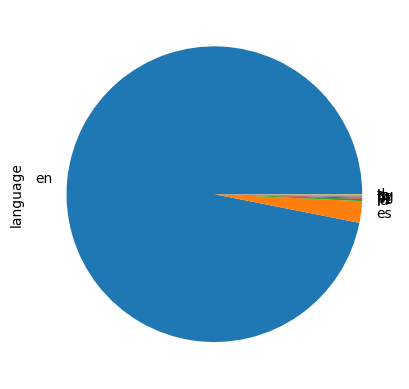

In [258]:
songs_lyrics["language"].value_counts().plot.pie();

Aggiungiamo poi al dataset la colonna _popularity_ presa dal dataset principale.

In [272]:
songs = pd.read_csv("songs.csv", sep=";")
songs_lyrics["popularity"] = songs["popularity"]
songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en,98
1,Cupid - Twin Ver.,FIFTY FIFTY,,None,97
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None,96
...,...,...,...,...,...
2380,Southbound,Beach Blvd,,None,21
2381,Dance with Somebody - Radio Version,Mando Diao,,None,16
2382,Flow,Desire Machines,,None,15
2383,Scared of the Dark,Everything Brighter,,None,11


Creiamo ora un dataset che contenga solo le canzoni con testo valido, da usare nell'addestramento e nella validazione di modelli predittivi che facciano uso di tecniche di NLP.

In [273]:
valid_songs_lyrics = songs_lyrics[songs_lyrics["lyrics"] != '']
valid_songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en,98
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en,96
5,Daylight,David Kushner,[Verse 1]\nTelling myself I won't go there\nOh...,en,96
6,TQG,KAROL G,"[Letra de ""TQG""]\n\n[Intro: KAROL G]\nLa que t...",es,96
...,...,...,...,...,...
2349,Lips Of An Angel,Hinder,"[Verse 1]\nHoney, why you callin’ me so late?\...",en,38
2351,Fake It,Seether,[Verse 1]\nWho's to know if your soul will fad...,en,37
2355,Switch,Will Smith,"[Intro]\nYo mic check, mic check, yeah here yo...",en,36
2361,The Selfish Gene,Marlon Percy,"5/1\n11:11 - ""Me, Chanel & Jameson""\nAazar & Y...",en,33


Costruiamo un semplice modello di tipo Bag of Words, così da avere una prima idea approssimativa di quanto la presenza di parole ricorrenti all'interno del testo di una canzone ne influenzi la popolarità. Facendo uso di un'istanza di **CountVectorizer**, possiamo creare una matrice testi-parole, nella quale ogni riga rappresenta una canzone e ogni colonna una parola che compare in almeno 15 canzoni. Questa soglia minima è stata aggiunta così da ridurre la dimensionalità dello spazio vettoriale. Inoltre, vengono anche rimosse le cosiddette _stopwords_ dai testi in lingua inglese.

Sulla matrice così creata viene effettuata una somma sulle colonne, il cui risultato è un vettore che associa ad ogni canzone la quantità di parole comuni che compaiono nel suo testo.

In [276]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=15, stop_words="english")
mat = cvect.fit_transform(valid_songs_lyrics["lyrics"])
lyric_popularity = mat.toarray().sum(axis=1)

In [278]:
np.corrcoef(lyric_popularity, valid_songs_lyrics["popularity"])

array([[ 1.        , -0.17209629],
       [-0.17209629,  1.        ]])

Si noti come sia presente una leggera correlazione negativa tra il vettore contenente le "popolarità dei testi" e quello contenente i valori di popolarità delle canzoni. Si tratta di un risultato certamente interessante, ma sarebbe sbagliato trarre la conclusione che un testo "banale" implica una minor popolarità della canzone.

In effetti, si è scelto di non includere per nulla questa feature nel dataset principale, sia perché i suoi valori dipendono fortemente da quali canzoni fanno parte del dataset in uso, sia per la difficoltà di gestire le canzoni che non hanno testo.

Si è quindi deciso di provare a cercare un insieme di termini _significativi_, ovvero parole la cui presenza influenza positivamente o negativamente la popolarità della canzone. Per fare ciò, si è fatto uso di un modello di regressione con regolarizzazione **LASSO**, in modo tale che l'insieme di parole desiderato sia composto da tutte le parole il cui coefficiente calcolato dal modello sia diverso da 0.  

In [262]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def print_eval(model, X, y_true):
    y_pred = model.predict(X_val)
    print("R2:", r2_score(y_true=y_val, y_pred=y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred)))
    print("MAE:", mean_absolute_error(y_true=y_val, y_pred=y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true=y_val, y_pred=y_pred))

In [263]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(lyrics["lyrics"], lyrics["popularity"], test_size=1/3, random_state=42)

Questa funzione crea un dizionario che associa ad ogni parola il suo coefficiente, a patto che esso sia superiore ad una data soglia.

In [283]:
def create_features_dict(model, threshold):
    features = model["vect"].get_feature_names_out()
    # Valid words is the number of words included in the vector space.
    print("Valid words:", len(features))
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features)) if abs(coefs[i]) > threshold}
    # Valuable words is the number of words whose coefficient is greater than a given threshold.
    print("Valuable words:", len(features_coefs))
    return features_coefs

Definiamo il modello e testiamolo con un valore di **alpha** basso. 

Ciascuna istanza di modello testata fa uso di un **CountVectorizer** che ignora le _stopword_ inglesi. Inoltre, si è preferito non dichiarare nessun valore per *min_df*, poiché esso avrebbe introdotto un bias implicito dovuto alla maggior presenza di testi inglesi nel dataset.

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GridSearchCV

model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=0.1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.06315586468637369
RMSE: 11.061529986609546
MAE: 8.42724323613601
MAPE: 0.1407573030632337
Valid words: 16727
Valuable words: 361


({'21': 0.4833590878462127,
  'ah': 0.10089415947759355,
  'ain': -0.18593561991473373,
  'alarm': -0.2840444117461012,
  'alive': -0.3286233181883921,
  'alright': 0.12472972048494307,
  'ass': -0.1082635290287712,
  'ay': -0.21827188611182968,
  'ba': -0.021256147777927458,
  'babe': 0.13145473113094513,
  'baby': 0.03783297186383591,
  'bad': -0.26555777915172263,
  'bah': -0.1269028856082774,
  'bailando': -0.04686992104234765,
  'ball': 0.01072942582883523,
  'band': 0.034029129863892706,
  'bands': 0.05877777783079525,
  'beat': -0.09402268924509753,
  'beautiful': 0.038367463079756046,
  'beep': -0.04164192983575824,
  'bennington': 0.3091972767769287,
  'best': -0.05438041449581812,
  'bet': 0.4323003267628989,
  'better': 0.055256433051548794,
  'bitch': 0.04225328582599081,
  'boom': -0.10327761025571963,
  'bop': -0.2581731045379907,
  'bottle': 0.16526786834104898,
  'bows': -0.5623397396992768,
  'boy': -0.05910076162233686,
  'boys': -0.2082020426255712,
  'break': 0.2259

Ovviamente, se **alpha** è prossimo a 0 (come nel modello soprastante) le parole considerate significative dal modello saranno tante. Proviamo un valore di **alpha** minore.

In [308]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.12578180824273477
RMSE: 10.685416368281778
MAE: 8.169971156707051
MAPE: 0.13709182200869818
Valid words: 16727
Valuable words: 19


({'ah': 0.06963107728851586,
  'ain': -0.0532495423894519,
  'boom': -0.04283960773278769,
  'chorus': 1.1130971490630395,
  'feel': 0.011319651014097997,
  'ft': -0.1274427073164763,
  'girl': -0.029464894196531248,
  'ha': 0.03507527125613425,
  'hey': -0.04741620265254192,
  'know': -0.018861445185839164,
  'make': -0.021173094486565652,
  'man': -0.07851645352386588,
  'oh': -0.012065538002012806,
  'ooh': 0.04154773032890413,
  'que': 0.44674064556227133,
  'said': 0.020334311068647495,
  've': 0.020769560978059397,
  'ya': -0.02535706986146616,
  'yeah': 0.031338460527590234},
 67.29101069734942)

Aumentando il parametro **alpha** da 0.01 a 1, le parole significative si riducono di quasi 20 volte. Tuttavia, il risultato appare ancora poco soddisfacente, in quanto tali parole sembrano piuttosto casuali e i coefficienti sono molto piccoli. Proviamo ad aumentare ancora il valore di **alpha**.

In [307]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=5))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.05332478360466941
RMSE: 11.119417413510135
MAE: 8.523911685334067
MAPE: 0.1430179692644062
Valid words: 16727
Valuable words: 1


({'chorus': 0.42599177927881754}, 69.25437811083174)

Con **alpha=5**, si ottiene un modello che fa uso di una sola parola per predire la popolarità di una canzone, ovvero _chorus_ (ritornello in italiano). 

Le metriche di accuratezza di questo modello sono in linea con quelle dei modelli precedenti, sebbene la dimensionalità sia stata ridotta drasticamente. Il termine _chorus_ è in sostanza l'unico presente nel testo di una canzone che ne possa effettivamente influenzare la popolarità, anche se in realtà esso non è parte del testo di alcuna canzone! 

Infatti, il formato delle _lyrics_ di Genius prevede che le strofe siano introdotte dal nome della parte corrispondente (_verse_, _chorus_, _interlude_, ...), ed ovviamente una canzone con molti ritornelli (e quindi in cui _chorus_ compare molte volte) tende ad essere più popolare di una canzone che non ne prevede neanche uno.

Pertanto, si è deciso di aggiungere al dataset principale una sola colonna, contenente il numero di ritornelli delle canzoni. I valori NaN che nascono dalla mancanza del testo vengono riempiti con la media della colonna. Cioè è discutibile, in quanto una canzone il cui testo non è presente su Genius potrebbe comunque avere dei ritornelli, tuttavia si è preferita questa strada rispetto al riempimento con il valore 0 o, peggio, alla rimozione completa delle canzoni che non hanno il testo.